# Geopandas - Map display

uses: geopandas, geojson
data: Czech districts, Czech cities, my 'volby' file (Czech election results).

In [26]:
%%capture
!pip install geopandas
!pip install geojson

In [2]:
from shapely.geometry import Point
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import geojson
import json
#import plotly.express as px


## Load the coordinates of Czech cities and towns

The last column: geometry
a city is a POINT


urllib : read from the internet

In [3]:
import urllib.request as urllib2
url='https://raw.githubusercontent.com/33bcdd/souradnice-mest/master/souradnice.csv'
## thanks to M.Zemek, T. Protivinsky a 33bcdd : https://github.com/33bcdd/souradnice-mest
with urllib2.urlopen(url) as f:
    cities=pd.read_csv(f)
cities['ISO3166-2']=cities['Kód kraje'].apply(lambda x: x[:2]+'-'+x[3:5])
cities = geopandas.GeoDataFrame(
    cities, geometry=geopandas.points_from_xy(cities.Longitude, cities.Latitude))
cities[:2]


,Obec,Kód obce,Okres,Kód okresu,Kraj,Kód kraje,PSČ,Latitude,Longitude,ISO3166-2,geometry
0,Abertamy,554979,Karlovy Vary,CZ0412,Karlovarský kraj,CZ041,36235,50.368855,12.818377,CZ-41,POINT (12.81838 50.36886)
1,Adamov,535826,České Budějovice,CZ0311,Jihočeský kraj,CZ031,37371,49.000624,14.539603,CZ-31,POINT (14.53960 49.00062)


## A way to get `Longitude` from the POINT

In [25]:
from shapely.geometry import Point
c=cities['geometry']
c.x[:3]

0    12.818377
1    14.539603
2    16.663955
dtype: float64

## Load the Czech districts geometry as `POLYGON`s

In [28]:
url='https://raw.githubusercontent.com/Plavit/Simple-Dash-Plotly-Map-Czech-Regions/main/maps/czech-regions-low-res.json'
## Thanks to Plavit https://github.com/Plavit/Simple-Dash-Plotly-Map-Czech-Regions

with urllib2.urlopen(url) as f:
    df = geopandas.read_file(f)
df[['ISO3166-2','name','geometry']].head(2)

,ISO3166-2,name,geometry
0,CZ-10,Hlavní město Praha,"POLYGON ((14.30639 49.99720, 14.33498 49.99385..."
1,CZ-64,Jihomoravský kraj,"POLYGON ((16.39204 49.58012, 16.37304 49.55359..."


## Load your user file (election results in this case)

We transform the district ID to the `ISO3166-2` format to be able to merge with the previous dataframe.

In [24]:
url='https://ktiml.mff.cuni.cz/~marta/volby2021.csv'
with urllib2.urlopen(url) as f:
  volby=pd.read_csv(f,sep='\t')
#    gj = geojson.load(f)
#gj.features[:2]
volby=volby.groupby('skupina').sum().transpose()
volby.reset_index(inplace=True)

volby['ISO3166-2']=volby['index'].apply(lambda x: x[:2]+'-'+x[3:5])
volby.head(2)

skupina,index,ANO,CSSD,KSCM,PIRSTAN,SPD,SPOLU,o,ISO3166-2
0,CZ010,109588,25116,13469,142100,28859,251090,57177,CZ-10
1,CZ020,176100,32245,24618,137532,55105,203091,77943,CZ-20


## Merge the DataFrames and create a GeoDataFrame

In [29]:
volby_geom=pd.merge(volby,df, on='ISO3166-2')
volby_geom=geopandas.GeoDataFrame(volby_geom)
volby_geom.columns

Index(['index', 'ANO', 'CSSD', 'KSCM', 'PIRSTAN', 'SPD', 'SPOLU', 'o',
       'ISO3166-2', 'admin_level', 'boundary', 'name', 'name:cs', 'name:de',
       'name:en', 'name:eo', 'name:fi', 'name:fr', 'name:hr', 'name:hu',
       'name:lt', 'name:nl', 'name:pl', 'name:ru', 'population', 'ref',
       'ref:NUTS', 'source', 'source:population', 'type', 'wikidata',
       'wikipedia', 'id', 'geometry'],
      dtype='object')

## And plot the election results of SPOLU party

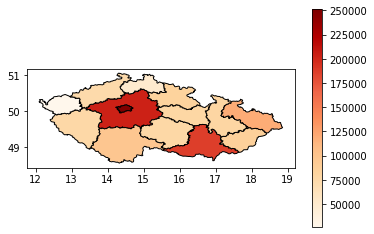

In [23]:
volby_geom.plot(column='SPOLU', cmap='OrRd', edgecolor='k', legend=True)

## The district capitals plot

<Figure size 720x1008 with 0 Axes>

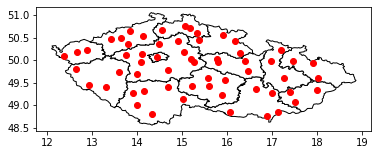

In [ ]:
plt.figure(figsize=(10,14))
okresy=cities[cities.Obec==cities.Okres]
ax = df["geometry"].plot(color='white', edgecolor='black')
okresy.plot(ax=ax,color='red')
plt.show()


## Public data with low resolutions: the countries and cities

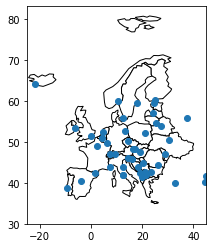

In [ ]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world_cities = geopandas.read_file(geopandas.datasets.get_path('naturalearth_cities'))

# We restrict to Europe.
eur=world[(world.continent == 'Europe')]
eu=eur[(eur.name!='Russia')]

## use the same geometry for countries and cities
ax = eu["geometry"].plot(color='white', edgecolor='black')

## I exclute the southern island cities as well.
world_cities[world_cities.geometry.y>38].plot(ax=ax)

plt.xlim(-25,45)
plt.ylim(30,83)
plt.show()